In [1]:
import numpy as np
import random
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [2]:
# Adjusting the create_square_with_random_values and create_sphere_with_random_values functions 
# to include a channel dimension and ensure the x, y, z outline the shape correctly

def create_square_with_channel(size, max_size=15):
    """Creates a 3D square with a channel dimension."""
    square = np.zeros((max_size, max_size, max_size, 1))  # Adding a channel dimension
    start_x, start_y, start_z = [random.randint(0, max_size - size) for _ in range(3)]

    # Assigning random values in the channel dimension for the square
    square[start_x:start_x+size, start_y:start_y+size, start_z:start_z+size, :] = np.random.rand(size, size, size, 1)

    return square

def create_sphere_with_channel(radius, max_size=15):
    """Creates a 3D sphere with a channel dimension."""
    sphere = np.zeros((max_size, max_size, max_size, 1))  # Adding a channel dimension
    center = max_size // 2

    # Assigning random values in the channel dimension for the sphere
    for x in range(max_size):
        for y in range(max_size):
            for z in range(max_size):
                if (x - center)**2 + (y - center)**2 + (z - center)**2 < radius**2:
                    sphere[x, y, z, :] = np.random.rand(1)

    return sphere

# Testing the updated functions
test_square_random_channel = create_square_with_channel(size=5)
test_sphere_random_channel = create_sphere_with_channel(radius=3)

(test_square_random_channel.shape, test_sphere_random_channel.shape)  # Should be (15, 15, 15, 1)


((15, 15, 15, 1), (15, 15, 15, 1))

In [3]:
from tqdm.notebook import tqdm

In [4]:
def generate_dataset_with_channel(num_samples):
    """Generates a dataset of squares and spheres with labels and channel dimension."""
    data = []
    labels = []

    for i in tqdm(range(num_samples)):
        if i % 2 == 0:  # Even index, generate square
            size = random.randint(3, 10)  # Random size for the square
            shape = create_square_with_channel(size)
            label = [1, 0]  # Label for square
        else:  # Odd index, generate sphere
            radius = random.randint(2, 7)  # Random radius for the sphere
            shape = create_sphere_with_channel(radius)
            label = [0, 1]  # Label for sphere

        data.append(shape)
        labels.append(label)

    # Convert to numpy arrays
    data = np.array(data)
    labels = np.array(labels)

    return data, labels

# Generate a new dataset with the updated function
num_samples = 50000  # Number of samples in the dataset
updated_dataset, updated_labels = generate_dataset_with_channel(num_samples)

(updated_dataset.shape, updated_labels.shape)  # Check the shapes of the updated dataset and labels


  0%|          | 0/50000 [00:00<?, ?it/s]

((50000, 15, 15, 15, 1), (50000, 2))

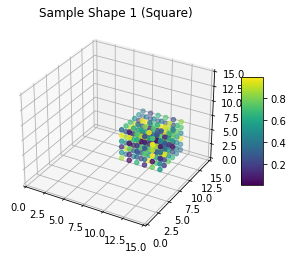

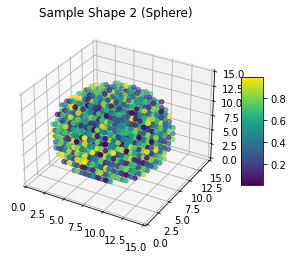

In [5]:

def plot_3d_shape(shape, title="3D Shape"):
    """Plots a 3D shape with intensity values as color."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract the x, y, z coordinates of the points and their intensity values
    x, y, z = np.where(shape > 0)
    intensities = shape[x, y, z]  # Intensity values for color

    # Plot these points as scatter plot with intensity values as color
    scatter = ax.scatter(x, y, z, c=intensities, cmap='viridis')
    ax.set_title(title)
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 15])
    ax.set_zlim([0, 15])
    # Adding a colorbar to represent intensity values
    plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

    plt.show()

# Visualize two shapes from the dataset
plot_3d_shape(updated_dataset[6, :, :, :, 0], title="Sample Shape 1 (Square)" if updated_labels[6,0] == 1 else "Sample Shape 1 (Sphere)")
plot_3d_shape(updated_dataset[157, :, :, :, 0], title="Sample Shape 2 (Square)" if updated_labels[7,0] == 1 else "Sample Shape 2 (Sphere)")


In [6]:
def interactive_plot_with_random_values(event, azim, elev):
    data = updated_dataset[event, :, :, :, 0]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = np.where(data > 0)  # Get coordinates where the shape exists
    c = data[x, y, z].flatten()  # Color values based on the random values, flattened
    scatter = ax.scatter(x, y, z, c=c, cmap='viridis')
    ax.view_init(azim=azim, elev=elev)
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 15])
    ax.set_zlim([0, 15])

    shape_type = "Square" if updated_labels[event, 0] == 1 else "Sphere"
    ax.set_title(f"Event {event}: {shape_type}")

    # Adding a colorbar to represent intensity values
    plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

    plt.show()

# Interactive widgets
event_slider = widgets.IntSlider(min=0, max=100, step=1, value=0, description='Event')
azim_slider = widgets.IntSlider(min=0, max=360, step=10, value=45, description='Azimuth')
elev_slider = widgets.IntSlider(min=-90, max=90, step=10, value=30, description='Elevation')

widgets.interactive(interactive_plot_with_random_values, event=event_slider, azim=azim_slider, elev=elev_slider)


interactive(children=(IntSlider(value=0, description='Event'), IntSlider(value=45, description='Azimuth', max=…

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, BatchNormalization, Dropout, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [8]:
X = np.zeros((0, 15,15, 15, 1))
pad = 'same'
kernels = 8

input_img = Input(shape=X.shape[1:])
x = Conv3D(kernels, (3,3,3), activation="relu", padding=pad)(input_img)
x = Conv3D(kernels, (3,3,3), activation='relu', padding=pad)(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)
x = BatchNormalization()(x)
x = Dropout(0.10)(x)

x = Conv3D(kernels, (3,3,3), activation="relu", padding=pad)(x)
x = Conv3D(kernels, (3,3,3), activation='relu', padding=pad)(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)
x = BatchNormalization()(x)
x = Dropout(0.10)(x)

x = Conv3D(kernels, (3,3,3), activation="relu", padding=pad)(x)
x = Conv3D(kernels, (3,3,3), activation='relu', padding=pad)(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)
x = BatchNormalization()(x)
x = Dropout(0.10)(x)

x = Flatten()(x)

x = Dense(32, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

outputs = Dense(2, activation='softmax', name='visualized_layer')(x)

model = Model(inputs=input_img, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

filepath="models/spherecube/Test_{val_accuracy:.2f}.model"  
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 15, 15, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 15, 15, 15, 8)     224       
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 15, 15, 8)     1736      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 7, 7, 8)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 7, 8)       32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 7, 7, 7, 8)        0     

In [9]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [10]:
history = model.fit(
    x=updated_dataset,
    y=updated_labels,
    validation_split=0.1,
    epochs=40,
    callbacks=[checkpoint]
    # Number of epochs to train
)

Epoch 1/40
1407/1407 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9837
Epoch 1: val_loss improved from inf to 0.00653, saving model to models/spherecube\Test_1.00.model


INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


1407/1407 [==============================] - 28s 17ms/step - loss: 0.0564 - accuracy: 0.9837 - val_loss: 0.0065 - val_accuracy: 0.9986
Epoch 2/40
1406/1407 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.9983
Epoch 2: val_loss improved from 0.00653 to 0.00042, saving model to models/spherecube\Test_1.00.model


INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


1407/1407 [==============================] - 23s 16ms/step - loss: 0.0081 - accuracy: 0.9983 - val_loss: 4.2054e-04 - val_accuracy: 0.9998
Epoch 3/40
1403/1407 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9980
Epoch 3: val_loss did not improve from 0.00042
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0076 - accuracy: 0.9980 - val_loss: 0.0016 - val_accuracy: 0.9996
Epoch 4/40
1404/1407 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9990
Epoch 4: val_loss did not improve from 0.00042
1407/1407 [==============================] - 20s 14ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 5/40
1407/1407 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9992
Epoch 5: val_loss improved from 0.00042 to 0.00013, saving model to models/spherecube\Test_1.00.model


INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


1407/1407 [==============================] - 24s 17ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 1.2942e-04 - val_accuracy: 1.0000
Epoch 6/40
1404/1407 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9991
Epoch 6: val_loss did not improve from 0.00013
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 2.7455e-04 - val_accuracy: 0.9998
Epoch 7/40
1403/1407 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9992
Epoch 7: val_loss did not improve from 0.00013
1407/1407 [==============================] - 20s 14ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 5.0360e-04 - val_accuracy: 0.9998
Epoch 8/40
1407/1407 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9994
Epoch 8: val_loss did not improve from 0.00013
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 4.3844e-04 - val_accuracy: 0.9998
Epoch 9/4

INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


1407/1407 [==============================] - 23s 16ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 8.4634e-05 - val_accuracy: 1.0000
Epoch 11/40
1407/1407 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9998
Epoch 11: val_loss improved from 0.00008 to 0.00005, saving model to models/spherecube\Test_1.00.model


INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


1407/1407 [==============================] - 24s 17ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 4.6980e-05 - val_accuracy: 1.0000
Epoch 12/40
1406/1407 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9996
Epoch 12: val_loss did not improve from 0.00005
1407/1407 [==============================] - 22s 15ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 7.0590e-05 - val_accuracy: 1.0000
Epoch 13/40
1405/1407 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995
Epoch 13: val_loss improved from 0.00005 to 0.00003, saving model to models/spherecube\Test_1.00.model


INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


1407/1407 [==============================] - 23s 17ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 3.0062e-05 - val_accuracy: 1.0000
Epoch 14/40
1407/1407 [==============================] - ETA: 0s - loss: 4.3421e-04 - accuracy: 0.9999
Epoch 14: val_loss did not improve from 0.00003
1407/1407 [==============================] - 21s 15ms/step - loss: 4.3421e-04 - accuracy: 0.9999 - val_loss: 6.0575e-04 - val_accuracy: 0.9998
Epoch 15/40
1404/1407 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.9997
Epoch 15: val_loss did not improve from 0.00003
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 3.4222e-04 - val_accuracy: 0.9998
Epoch 16/40
1404/1407 [============================>.] - ETA: 0s - loss: 0.0019 - accuracy: 0.9997
Epoch 16: val_loss did not improve from 0.00003
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0013 - val_accuracy: 0.9998

INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


1407/1407 [==============================] - 24s 17ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 2.9096e-06 - val_accuracy: 1.0000
Epoch 19/40
1407/1407 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997
Epoch 19: val_loss did not improve from 0.00000
1407/1407 [==============================] - 22s 15ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 6.8544e-04 - val_accuracy: 0.9998
Epoch 20/40
1404/1407 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998
Epoch 20: val_loss did not improve from 0.00000
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 9.2713e-05 - val_accuracy: 1.0000
Epoch 21/40
1407/1407 [==============================] - ETA: 0s - loss: 5.6973e-04 - accuracy: 0.9999
Epoch 21: val_loss did not improve from 0.00000
1407/1407 [==============================] - 22s 15ms/step - loss: 5.6973e-04 - accuracy: 0.9999 - val_loss: 2.5485e-04 - val_accuracy: 0.

INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


1407/1407 [==============================] - 24s 17ms/step - loss: 2.8399e-04 - accuracy: 1.0000 - val_loss: 1.5497e-06 - val_accuracy: 1.0000
Epoch 32/40
1407/1407 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9998
Epoch 32: val_loss did not improve from 0.00000
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 1.2678e-04 - val_accuracy: 1.0000
Epoch 33/40
1405/1407 [============================>.] - ETA: 0s - loss: 4.5170e-04 - accuracy: 0.9999
Epoch 33: val_loss did not improve from 0.00000
1407/1407 [==============================] - 22s 15ms/step - loss: 4.5133e-04 - accuracy: 0.9999 - val_loss: 1.6909e-05 - val_accuracy: 1.0000
Epoch 34/40
1405/1407 [============================>.] - ETA: 0s - loss: 3.4446e-04 - accuracy: 1.0000
Epoch 34: val_loss did not improve from 0.00000
1407/1407 [==============================] - 22s 16ms/step - loss: 3.4416e-04 - accuracy: 1.0000 - val_loss: 7.8483e-04 - val_

INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


INFO:tensorflow:Assets written to: models/spherecube\Test_1.00.model\assets


1407/1407 [==============================] - 24s 17ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 8.7579e-07 - val_accuracy: 1.0000
Epoch 39/40
1404/1407 [============================>.] - ETA: 0s - loss: 3.7996e-04 - accuracy: 0.9999
Epoch 39: val_loss did not improve from 0.00000
1407/1407 [==============================] - 21s 15ms/step - loss: 3.7941e-04 - accuracy: 0.9999 - val_loss: 1.4613e-06 - val_accuracy: 1.0000
Epoch 40/40
1404/1407 [============================>.] - ETA: 0s - loss: 5.5869e-04 - accuracy: 0.9999
Epoch 40: val_loss did not improve from 0.00000
1407/1407 [==============================] - 21s 15ms/step - loss: 5.5785e-04 - accuracy: 0.9999 - val_loss: 2.8277e-06 - val_accuracy: 1.0000


In [11]:
model= tf.keras.models.load_model('models/spherecube\Test_1.00.model')

In [12]:
#input_data = total_X_tensor[:5000].astype(np.float32)  # Ensure the input data type is float32
class_indices = np.argmax(updated_labels, axis=1)  # Convert one-hot encoding to class indices

In [13]:
with tf.device('CPU'):
    updated_dataset_tensor = tf.convert_to_tensor(updated_dataset)

In [14]:
def compute_gradients(model, X, class_index):
    with tf.GradientTape(persistent=True) as tape:  # Set the tape to be persistent
        tape.watch(X)
        outputs = model(X)
        target_output = outputs[:, class_index]

    gradients_X = tape.gradient(target_output, X)
    return gradients_X 

saliency_maps_X = []

for i in tqdm(range(2000)):
    gradients_X = compute_gradients(model, updated_dataset_tensor[i:i+1], class_indices[i])
    saliency_map_X = np.mean(np.abs(gradients_X.numpy()), axis=(0, -1))
    saliency_maps_X.append(saliency_map_X)


saliency_maps_X = np.array(saliency_maps_X)
#saliency_maps_X = (saliency_maps_X - saliency_maps_X.min()) / (saliency_maps_X.max() - saliency_maps_X.min())


  0%|          | 0/2000 [00:00<?, ?it/s]

In [15]:
saliency_maps_X.shape

(2000, 15, 15, 15)

In [19]:
def interactive_plot_with_saliency(event, azim, elev, thres):
    data = updated_dataset[event, :, :, :, 0]
    saliency_data = saliency_maps_X[event, :, :, :]

    fig = plt.figure(figsize=(16, 8))

    # Plot for the event
    ax1 = fig.add_subplot(121, projection='3d')
    x, y, z = np.where(data > 0)
    c = data[x, y, z].flatten()
    scatter = ax1.scatter(x, y, z, c=c, cmap='viridis')
    ax1.view_init(azim=azim, elev=elev)
    ax1.set_xlim([0, 15])
    ax1.set_ylim([0, 15])
    ax1.set_zlim([0, 15])
    ax1.set_title(f"Event {event}")

    # Plot for the saliency map
    ax2 = fig.add_subplot(122, projection='3d')
    x, y, z = np.where(saliency_data > thres/(1.0E16))
    c = saliency_data[x, y, z].flatten()
    scatter2 = ax2.scatter(x, y, z, c=c, cmap='hot')  # Using a different colormap for clarity
    ax2.view_init(azim=azim, elev=elev)
    ax2.set_xlim([0, 15])
    ax2.set_ylim([0, 15])
    ax2.set_zlim([0, 15])
    ax2.set_title(f"Saliency Map for Event {event}")

    plt.show()
    
event_slider = widgets.IntSlider(min=0, max=100, step=1, value=0, description='Event')

thres_slider = widgets.IntSlider(min=0, max=100,step=1, value=0, description='Threshold')
# Interactive widgets
widgets.interactive(interactive_plot_with_saliency, event=event_slider, azim=azim_slider, elev=elev_slider,thres=thres_slider)


interactive(children=(IntSlider(value=0, description='Event'), IntSlider(value=50, description='Azimuth', max=…

In [25]:
x, y, z = np.where(saliency_maps_X > 0)

ValueError: too many values to unpack (expected 3)

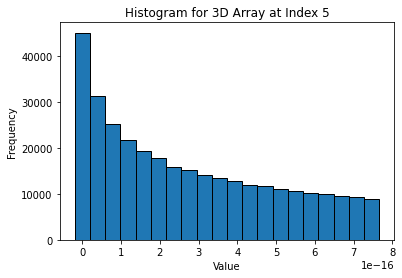

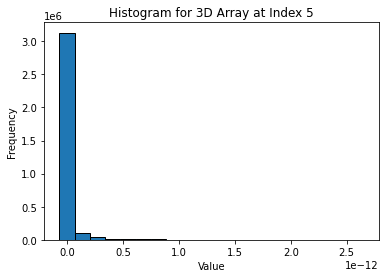

In [18]:
import matplotlib.pyplot as plt

def plot_histogram(data, index):
    """
    Plot the histogram for a specific 3D array in the dataset.
    Args:
    data (numpy.ndarray): The 4D dataset.
    index (int): The index of the 3D array to plot.
    """
    hist, bins = np.histogram(data, bins=20, range=(0, np.max(data[index])))
    plt.figure()
    plt.bar(bins[:-1], hist, width=np.diff(bins), edgecolor='black')
    plt.title(f'Histogram for 3D Array at Index {index}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# Example: Plot histogram for the first saliency map
plot_histogram(saliency_maps_X[1::2], 5)
plot_histogram(saliency_maps_X[::2], 5)

In [20]:
def calculate_true_center_of_mass(data):
    """
    Calculate the true center of mass for each 3D array in a 4D dataset.
    Args:
    data (numpy.ndarray): The 4D dataset.

    Returns:
    numpy.ndarray: An array of center of mass coordinates for each 3D array.
    """
    centers = []
    for d in data:
        coords = np.indices(d.shape)
        total = d.sum()
        center = np.sum(d * coords, axis=(1, 2, 3)) / total
        centers.append(center)
    return np.array(centers)


# Calculate center of mass for saliency maps and input images
saliency_centers = calculate_true_center_of_mass(saliency_maps_X)
input_centers = calculate_true_center_of_mass(updated_dataset[:, :, :, :, 0]) 
saliency_centers[0], input_centers[0]

(array([6.96165769, 6.8877196 , 6.63984772]),
 array([4.62420434, 5.47878396, 7.60156964]))

(array([  5.,   4.,  12.,  43.,  94., 130., 188., 206., 258., 120.,  28.,
         17.,  26.,  30.,  33.,  34.,  36.,  39.,  41.,  49.,  51.,  37.,
         48.,  38.,  36.,  41.,  44.,  45.,  32.,  37.,  28.,  18.,  19.,
         28.,  17.,  18.,  11.,  10.,  13.,   9.,   3.,   8.,   4.,   4.,
          1.,   1.,   2.,   2.,   1.,   1.]),
 array([ 0.86696952,  1.06705201,  1.2671345 ,  1.46721699,  1.66729949,
         1.86738198,  2.06746447,  2.26754696,  2.46762945,  2.66771194,
         2.86779444,  3.06787693,  3.26795942,  3.46804191,  3.6681244 ,
         3.8682069 ,  4.06828939,  4.26837188,  4.46845437,  4.66853686,
         4.86861936,  5.06870185,  5.26878434,  5.46886683,  5.66894932,
         5.86903181,  6.06911431,  6.2691968 ,  6.46927929,  6.66936178,
         6.86944427,  7.06952677,  7.26960926,  7.46969175,  7.66977424,
         7.86985673,  8.06993923,  8.27002172,  8.47010421,  8.6701867 ,
         8.87026919,  9.07035168,  9.27043418,  9.47051667,  9.67059916,
 

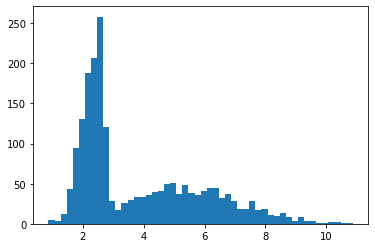

In [21]:
import math
def distance_3d(point1, point2):
    x1, y1, z1 = point1
    x2, y2, z2 = point2
    distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)
    return distance

Diff_sal_in=[]
for i in range(len(saliency_centers)):
    Diff_sal_in.append(distance_3d(saliency_centers[i],input_centers[i]))
plt.hist(Diff_sal_in, bins=50)

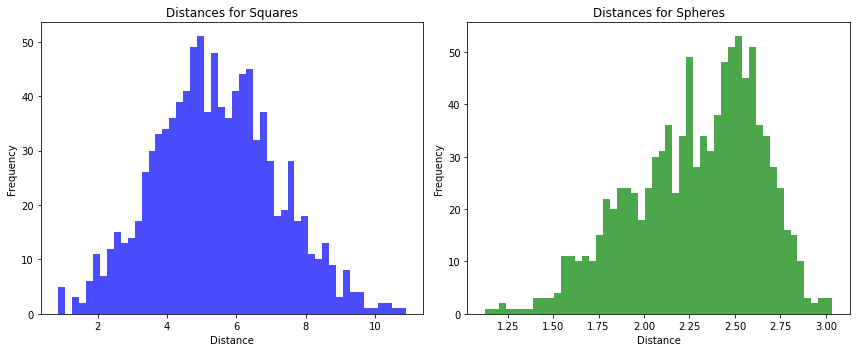

In [22]:
import matplotlib.pyplot as plt

# Separate distances by class
class_0_distances = [d for i, d in enumerate(Diff_sal_in) if np.array_equal(updated_labels[i], [1, 0])]
class_1_distances = [d for i, d in enumerate(Diff_sal_in) if np.array_equal(updated_labels[i], [0, 1])]

# Plot histograms for each class
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(class_0_distances, bins=50, color='blue', alpha=0.7)
plt.title("Distances for Squares")
plt.xlabel("Distance")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(class_1_distances, bins=50, color='green', alpha=0.7)
plt.title("Distances for Spheres")
plt.xlabel("Distance")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [358]:
np.count_nonzero(img)

array([[[[[0.52353969],
          [0.72380215],
          [0.2377662 ],
          ...,
          [0.93174964],
          [0.08154508],
          [0.08447184]],

         [[0.38444574],
          [0.84534928],
          [0.67927121],
          ...,
          [0.07223505],
          [0.19635911],
          [0.40018973]],

         [[0.34922661],
          [0.07599939],
          [0.83575121],
          ...,
          [0.63337668],
          [0.39807741],
          [0.7842965 ]],

         ...,

         [[0.0708069 ],
          [0.38295899],
          [0.33325287],
          ...,
          [0.28377801],
          [0.44045145],
          [0.34572798]],

         [[0.232529  ],
          [0.61991876],
          [0.62618956],
          ...,
          [0.75661794],
          [0.29511692],
          [0.87939702]],

         [[0.15758652],
          [0.82432697],
          [0.96282425],
          ...,
          [0.02329201],
          [0.10368916],
          [0.99836242]]],


        [[[0.2170

In [366]:
updated_labels[1::2]

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [23]:
# Define size categories (you can adjust these based on your data)
size_categories = [50, 100, 150, 200, 250,300,350, np.inf]  # Example categories

# Calculate the size of each sphere
sphere_sizes = [np.count_nonzero(img) for img in updated_dataset[1::2]]

# Categorize spheres
categorized_distances = [[] for _ in range(len(size_categories) - 1)]
for size, distance in zip(sphere_sizes, Diff_sal_in):
    for i in range(len(size_categories) - 1):
        if size_categories[i] <= size < size_categories[i + 1]:
            categorized_distances[i].append(distance)
            break


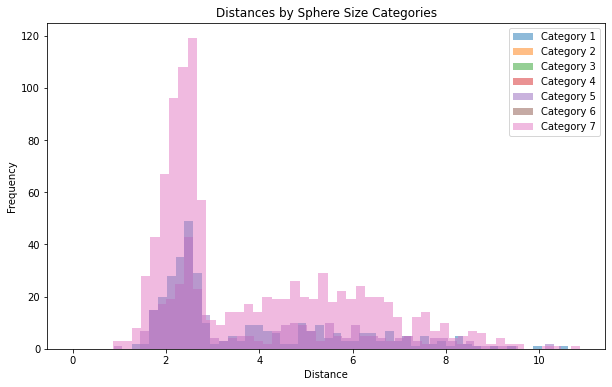

In [24]:
# Plotting
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Adjust as needed
plt.figure(figsize=(10, 6))
for i in range(len(categorized_distances)):
    plt.hist(categorized_distances[i], bins=50,  alpha=0.5, label=f'Category {i+1}')
plt.title("Distances by Sphere Size Categories")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()


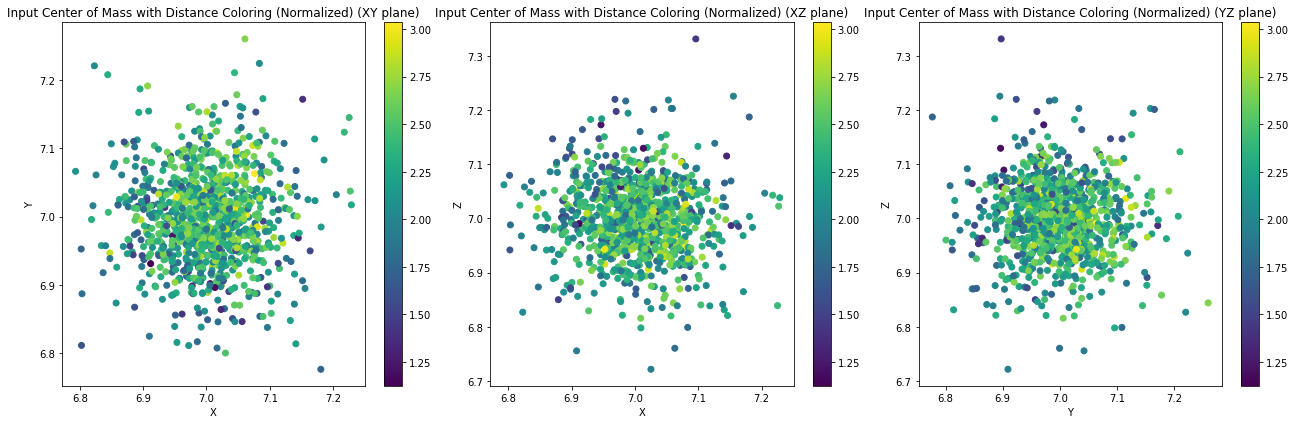

In [25]:
import matplotlib.pyplot as plt

def plot_3d_scatter(centers, distances, title):
    """
    Plot a 3D scatter plot of centers of mass with distances as color.
    
    Args:
    centers (numpy.ndarray): Array of center of mass coordinates.
    distances (list): List of distances corresponding to each center.
    title (str): Title for the plot.
    """
    
    
    fig = plt.figure(figsize=(18, 6))

    # XY plot
    ax = fig.add_subplot(131)
    scatter = ax.scatter([c[0] for c in centers], [c[1] for c in centers], c=distances, cmap='viridis')
    ax.set_title(f'{title} (XY plane)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.colorbar(scatter, ax=ax)

    # XZ plot
    ax = fig.add_subplot(132)
    scatter = ax.scatter([c[0] for c in centers], [c[2] for c in centers], c=distances, cmap='viridis')
    ax.set_title(f'{title} (XZ plane)')
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    plt.colorbar(scatter, ax=ax)

    # YZ plot
    ax = fig.add_subplot(133)
    scatter = ax.scatter([c[1] for c in centers], [c[2] for c in centers], c=distances, cmap='viridis')
    ax.set_title(f'{title} (YZ plane)')
    ax.set_xlabel('Y')
    ax.set_ylabel('Z')
    plt.colorbar(scatter, ax=ax)

    plt.tight_layout()
    plt.show()

import numpy as np

def normalize_data(data):
    """
    Normalize the data to a range of 0 to 1.
    
    Args:
    data (list): List of data values.
    
    Returns:
    numpy.ndarray: Normalized data.
    """
    data = np.array(data)
    min_val = data.min()
    max_val = data.max()
    normalized = (data - min_val) / (max_val - min_val)
    return normalized

# Normalize the distances
normalized_distances = normalize_data(Diff_sal_in)

# Then use the normalized_distances for the color in the scatter plot
plot_3d_scatter(input_centers[1:len(Diff_sal_in):2], Diff_sal_in[1::2], "Input Center of Mass with Distance Coloring (Normalized)")


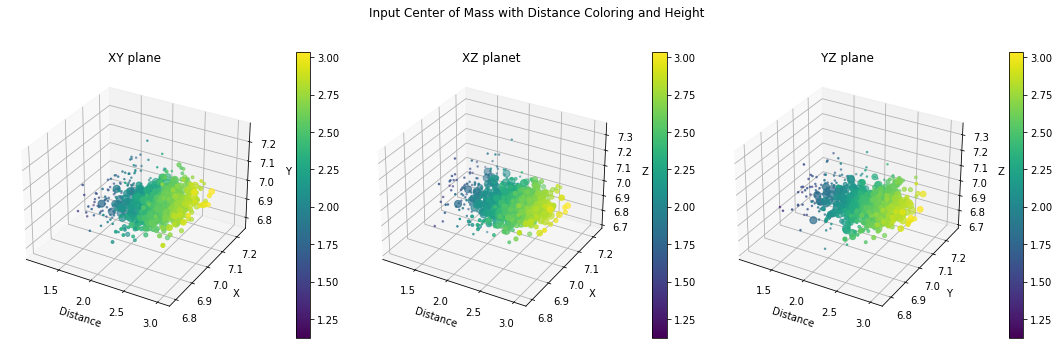

In [26]:
from mpl_toolkits.mplot3d import Axes3D

size = np.array(sphere_sizes[:1000])
min_val = size.min()
max_val = size.max()
size = ((size - min_val) / (max_val - min_val))*50


def plot_3d_scatter(centers, distances, title):
    """
    Plot a 3D scatter plot of centers of mass with distances as both color and z-height.
    
    Args:
    centers (numpy.ndarray): Array of center of mass coordinates.
    distances (list): List of distances corresponding to each center.
    title (str): Title for the plot.
    """
    fig = plt.figure(figsize=(15, 5))

    # XY plane with z-height
    ax = fig.add_subplot(131, projection='3d')
    scatter = ax.scatter(distances,[c[0] for c in centers], [c[1] for c in centers], c=distances,s=size, cmap='viridis')
    ax.set_title('XY plane')
    ax.set_ylabel('X')
    ax.set_zlabel('Y')
    ax.set_xlabel('Distance')
    plt.colorbar(scatter, ax=ax, pad=0.1)

    # XZ plane with z-height
    ax = fig.add_subplot(132, projection='3d')
    scatter = ax.scatter(distances, [c[0] for c in centers], [c[2] for c in centers], c=distances,s=size, cmap='viridis')
    ax.set_title('XZ planet')
    ax.set_ylabel('X')
    ax.set_xlabel('Distance')
    ax.set_zlabel('Z')
    plt.colorbar(scatter, ax=ax, pad=0.1)

    # YZ plane with z-height
    ax = fig.add_subplot(133, projection='3d')
    scatter = ax.scatter(distances, [c[1] for c in centers], [c[2] for c in centers], c=distances,s=size, cmap='viridis')
    ax.set_title('YZ plane')
    ax.set_xlabel('Distance')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.colorbar(scatter, ax=ax, pad=0.1)

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Use the function with the normalized data
plot_3d_scatter(input_centers[1:len(Diff_sal_in):2], Diff_sal_in[1::2], "Input Center of Mass with Distance Coloring and Height")


In [393]:
len(sphere_sizes[:1000]),len(input_centers[1:len(Diff_sal_in):2]),len( Diff_sal_in[1::2])

(1000, 1000, 1000)

# Noise

In [430]:
def create_square_with_channel_and_noise(size, max_size=15, noise_intensity=0.2):
    """Creates a 3D square with a channel dimension and adds noise."""
    # Create a square with uniform values in the specified range
    square = np.random.uniform(low=0, high=noise_intensity, size=(max_size, max_size, max_size, 1))
    
    # Define the start positions for the square
    start_x, start_y, start_z = [random.randint(0, max_size - size) for _ in range(3)]

    # Assign a higher value within the square boundary to make it distinct from the noise
    square[start_x:start_x+size, start_y:start_y+size, start_z:start_z+size, :] = np.random.rand(size, size, size, 1)

    return square

def create_sphere_with_channel_and_noise(radius, max_size=15, noise_intensity=0.2):
    """Creates a 3D sphere with a channel dimension and adds noise."""
    # Create a sphere with uniform values in the specified range
    sphere = np.random.uniform(low=0, high=noise_intensity, size=(max_size, max_size, max_size, 1))
    
    center = max_size // 2

    # Assign a higher value within the sphere boundary to make it distinct from the noise
    for x in range(max_size):
        for y in range(max_size):
            for z in range(max_size):
                if (x - center)**2 + (y - center)**2 + (z - center)**2 < radius**2:
                    sphere[x, y, z, :] = np.random.rand(1)

    return sphere

# Testing the updated functions with noise
test_square_with_noise = create_square_with_channel_and_noise(size=5)
test_sphere_with_noise = create_sphere_with_channel_and_noise(radius=3)

(test_square_with_noise.shape, test_sphere_with_noise.shape)  # Should be (15, 15, 15, 1)


((15, 15, 15, 1), (15, 15, 15, 1))

In [418]:
test_square_random_channel

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [431]:
def generate_dataset_with_channel(num_samples):
    """Generates a dataset of squares and spheres with labels and channel dimension."""
    data = []
    labels = []

    for i in tqdm(range(num_samples)):
        if i % 2 == 0:  # Even index, generate square
            size = random.randint(3, 10)  # Random size for the square
            shape = create_square_with_channel_and_noise(size)
            label = [1, 0]  # Label for square
        else:  # Odd index, generate sphere
            radius = random.randint(2, 7)  # Random radius for the sphere
            shape = create_sphere_with_channel_and_noise(radius)
            label = [0, 1]  # Label for sphere

        data.append(shape)
        labels.append(label)

    # Convert to numpy arrays
    data = np.array(data)
    labels = np.array(labels)

    return data, labels

# Generate a new dataset with the updated function
num_samples = 1000  # Number of samples in the dataset
updated_dataset_noise, updated_labels_noise = generate_dataset_with_channel(num_samples)

(updated_dataset_noise.shape, updated_labels_noise.shape)  # Check the shapes of the updated dataset and labels


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 475.31it/s]


((1000, 15, 15, 15, 1), (1000, 2))

In [432]:
def interactive_plot_with_random_values_noise(event, azim, elev):
    data = updated_dataset_noise[event, :, :, :, 0]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = np.where(data > 0)  # Get coordinates where the shape exists
    c = data[x, y, z].flatten()  # Color values based on the random values, flattened
    scatter = ax.scatter(x, y, z, c=c, cmap='viridis')
    ax.view_init(azim=azim, elev=elev)
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 15])
    ax.set_zlim([0, 15])

    shape_type = "Square" if updated_labels_noise[event, 0] == 1 else "Sphere"
    ax.set_title(f"Event {event}: {shape_type}")

    # Adding a colorbar to represent intensity values
    plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

    plt.show()

# Interactive widgets
event_slider = widgets.IntSlider(min=0, max=100, step=1, value=0, description='Event')
azim_slider = widgets.IntSlider(min=0, max=360, step=10, value=45, description='Azimuth')
elev_slider = widgets.IntSlider(min=-90, max=90, step=10, value=30, description='Elevation')

widgets.interactive(interactive_plot_with_random_values_noise, event=event_slider, azim=azim_slider, elev=elev_slider)


interactive(children=(IntSlider(value=0, description='Event'), IntSlider(value=45, description='Azimuth', max=…

In [433]:
model.evaluate(updated_dataset_noise, updated_labels_noise)

32/32 [==============================] - 0s 11ms/step - loss: 0.5924 - accuracy: 0.8970


[0.5923582911491394, 0.8970000147819519]

In [434]:
#input_data = total_X_tensor[:5000].astype(np.float32)  # Ensure the input data type is float32
class_indices = np.argmax(updated_labels_noise, axis=1)  # Convert one-hot encoding to class indices

In [435]:
with tf.device('CPU'):
    updated_dataset_noise_tensor = tf.convert_to_tensor(updated_dataset_noise)

In [436]:
def compute_gradients(model, X, class_index):
    with tf.GradientTape(persistent=True) as tape:  # Set the tape to be persistent
        tape.watch(X)
        outputs = model(X)
        target_output = outputs[:, class_index]

    gradients_X = tape.gradient(target_output, X)
    return gradients_X 

saliency_maps_X_noise = []

for i in tqdm(range(1000)):
    gradients_X = compute_gradients(model, updated_dataset_noise_tensor[i:i+1], class_indices[i])
    saliency_map_X = np.mean(np.abs(gradients_X.numpy()), axis=(0, -1))
    saliency_maps_X_noise.append(saliency_map_X)


saliency_maps_X_noise = np.array(saliency_maps_X_noise)
#saliency_maps_X = (saliency_maps_X - saliency_maps_X.min()) / (saliency_maps_X.max() - saliency_maps_X.min())


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 31.08it/s]


In [427]:
saliency_maps_X_noise.shape

(1000, 15, 15, 15)

In [445]:
def interactive_plot_with_saliency(event, azim, elev):
    data = updated_dataset_noise[event, :, :, :, 0]
    saliency_data = saliency_maps_X_noise[event, :, :, :]

    fig = plt.figure(figsize=(16, 8))

    # Plot for the event
    ax1 = fig.add_subplot(121, projection='3d')
    x, y, z = np.where(data > 0)
    c = data[x, y, z].flatten()
    scatter = ax1.scatter(x, y, z, c=c, cmap='viridis')
    ax1.view_init(azim=azim, elev=elev)
    ax1.set_xlim([0, 15])
    ax1.set_ylim([0, 15])
    ax1.set_zlim([0, 15])
    ax1.set_title(f"Event {event}")

    # Plot for the saliency map
    ax2 = fig.add_subplot(122, projection='3d')
    x, y, z = np.where(saliency_data > 0.1E-13)
    c = saliency_data[x, y, z].flatten()
    scatter2 = ax2.scatter(x, y, z, c=c, cmap='hot')  # Using a different colormap for clarity
    ax2.view_init(azim=azim, elev=elev)
    ax2.set_xlim([0, 15])
    ax2.set_ylim([0, 15])
    ax2.set_zlim([0, 15])
    ax2.set_title(f"Saliency Map for Event {event}")

    plt.show()
    
event_slider = widgets.IntSlider(min=0, max=100, step=1, value=0, description='Event')
# Interactive widgets
widgets.interactive(interactive_plot_with_saliency, event=event_slider, azim=azim_slider, elev=elev_slider)


interactive(children=(IntSlider(value=0, description='Event'), IntSlider(value=45, description='Azimuth', max=…

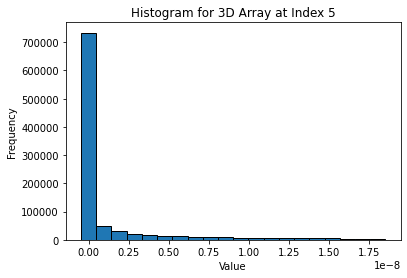

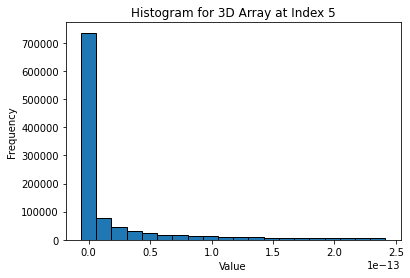

In [443]:

plot_histogram(saliency_maps_X_noise[1::2], 5)
plot_histogram(saliency_maps_X_noise[::2], 5)

In [ ]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm

def smooth_grad(model, X, class_index, noise_level_X=0.1, num_samples=50):
    """
    Applies the SmoothGrad method to compute the saliency map for both inputs.

    :param model: The trained model.
    :param X: The input image tensor.
    :param Rec_tensor: The additional tensor used by the model.
    :param class_index: The index of the class for which the saliency is computed.
    :param noise_level_X: The standard deviation of the Gaussian noise to add to the input image.
    :param noise_level_Rec: The standard deviation of the Gaussian noise to add to the Rec tensor.
    :param num_samples: The number of noisy samples to generate for averaging.
    :return: Two averaged gradients for X and Rec_tensor, which are the SmoothGrad saliency maps.
    """
    # Calculate the shape for noise generation
    noise_shape_X = X.shape


    # Initialize the accumulators for the gradients
    accumulated_gradients_X = 0


    # Generate noisy samples and accumulate gradients
    for _ in range(num_samples):
        noise_X = tf.random.normal(
            noise_shape_X,
            stddev=noise_level_X * (tf.reduce_max(X) - tf.reduce_min(X)),
            dtype=tf.float64
        )

      

        noisy_X = X + noise_X

        gradients_X = compute_gradients(model, noisy_X, class_index)
        accumulated_gradients_X += gradients_X


    # Average the accumulated gradients
    smooth_grad_X = accumulated_gradients_X / num_samples

    
    return smooth_grad_X

# Define your compute_gradients function here

saliency_maps_X = []


for i in tqdm(range(10)):
    smooth_gradients_X = smooth_grad(
        model=model,
        X=updated_dataset_tensor[i:i+1], 
        class_index=class_indices[i])

    if not np.any(np.isnan(smooth_gradients_X.numpy())):
        saliency_map_X = np.nanmean(np.abs(smooth_gradients_X.numpy()), axis=(0, -1))
        saliency_maps_X.append(saliency_map_X)
    else:
        print(f"NaN detected in gradients for sample {i} for X")

# Convert the lists to arrays and normalize
saliency_maps_X = np.array(saliency_maps_X)
#saliency_maps_X = (saliency_maps_X - saliency_maps_X.min()) / (saliency_maps_X.max() - saliency_maps_X.min())



In [ ]:
saliency_maps_X.max()

In [ ]:
def interactive_plot_with_saliency(event, azim, elev):
    data = updated_dataset[event, :, :, :, 0]
    saliency_data = saliency_maps_X[event, :, :, :]

    fig = plt.figure(figsize=(16, 8))

    # Plot for the event
    ax1 = fig.add_subplot(121, projection='3d')
    x, y, z = np.where(data > 0)
    c = data[x, y, z].flatten()
    
    scatter = ax1.scatter(x, y, z, c=c, cmap='viridis')
    ax1.view_init(azim=azim, elev=elev)
    ax1.set_xlim([0, 15])
    ax1.set_ylim([0, 15])
    ax1.set_zlim([0, 15])
    ax1.set_title(f"Event {event}")

    # Plot for the saliency map
    ax2 = fig.add_subplot(122, projection='3d')
    x, y, z = np.where(saliency_data > 0)
    
    c = saliency_data[x, y, z].flatten()
    scatter2 = ax2.scatter(x, y, z, c=c, cmap='hot')  # Using a different colormap for clarity
    ax2.view_init(azim=azim, elev=elev)
    ax2.set_xlim([0, 15])
    ax2.set_ylim([0, 15])
    ax2.set_zlim([0, 15])
    ax2.set_title(f"Saliency Map for Event {event}")

    plt.show()

# Interactive widgets
widgets.interactive(interactive_plot_with_saliency, event=event_slider, azim=azim_slider, elev=elev_slider)


In [280]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 15, 15, 15, 1)]   0         
                                                                 
 conv3d_26 (Conv3D)          (None, 15, 15, 15, 8)     224       
                                                                 
 conv3d_27 (Conv3D)          (None, 15, 15, 15, 8)     1736      
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 7, 7, 7, 8)       0         
 g3D)                                                            
                                                                 
 batch_normalization_23 (Bat  (None, 7, 7, 7, 8)       32        
 chNormalization)                                                
                                                                 
 dropout_23 (Dropout)        (None, 7, 7, 7, 8)        0   

In [290]:
target_layer = model.get_layer(name="conv3d_26")

In [291]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0, "float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

def replace_relu_with_guided_relu(model):
    for layer in model.layers:
        if hasattr(layer, 'activation'):
            if 'relu' in str(layer.activation):
                layer.activation = guidedRelu
    return model



In [189]:
import scipy.ndimage as ndi

In [293]:
def compute_grad_cam(model, target_layer, inputs, class_index):
    # Define the Grad-CAM model
    grad_cam_model = tf.keras.Model(inputs=model.inputs, outputs=[model.output, target_layer.output])
    
    # Get the score for the class index
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        outputs, target_layer_output = grad_cam_model(inputs)
        target_output = outputs[:, class_index]

    # Compute the gradient of the class output value with respect to the feature map
    grads = tape.gradient(target_output, target_layer_output)

    # Pool gradients over all axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))

    # Weigh the output feature map with the computed gradient values
    grad_cam = tf.reduce_sum(target_layer_output * pooled_grads, axis=-1)

    # Apply ReLU to the Grad-CAM (optional but recommended)
    grad_cam = tf.nn.relu(grad_cam)

    # Normalize the Grad-CAM
    grad_cam = (grad_cam - tf.reduce_min(grad_cam)) / (tf.reduce_max(grad_cam) - tf.reduce_min(grad_cam) + tf.keras.backend.epsilon())

    # Resize the Grad-CAM to match the input dimensions
        # Convert to numpy and inspect the shape

    # Convert to numpy and remove the batch dimension
    grad_cam_numpy = grad_cam.numpy().squeeze(axis=0)
    #print("Shape of grad_cam_numpy after squeezing:", grad_cam_numpy.shape)

    # Calculate zoom factors
    zoom_factors = [
        inputs.shape[1] / grad_cam_numpy.shape[0], 
        inputs.shape[2] / grad_cam_numpy.shape[1], 
        inputs.shape[3] / grad_cam_numpy.shape[2]
    ]
    #print("Zoom factors:", zoom_factors)

    # Resize the Grad-CAM
    grad_cam_resized = ndi.zoom(grad_cam_numpy, zoom_factors)

    # Convert back to a TensorFlow tensor and expand dimensions to match the input
    grad_cam_resized = tf.convert_to_tensor(grad_cam_resized)
    grad_cam_expanded = tf.expand_dims(grad_cam_resized, axis=-1)

    return grad_cam_expanded

# Example usage
class_index = 1  # or 0, depending on the class you want to visualize
grad_cam = compute_grad_cam(model, target_layer, updated_dataset_tensor[0:1], class_indices[0])


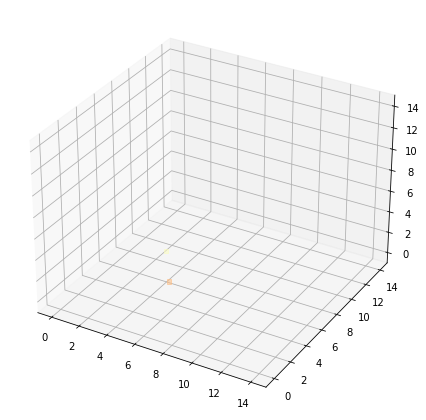

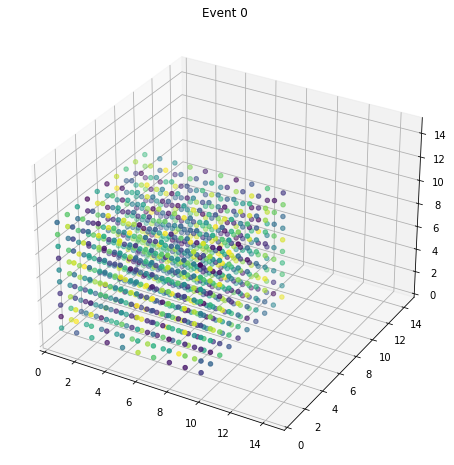

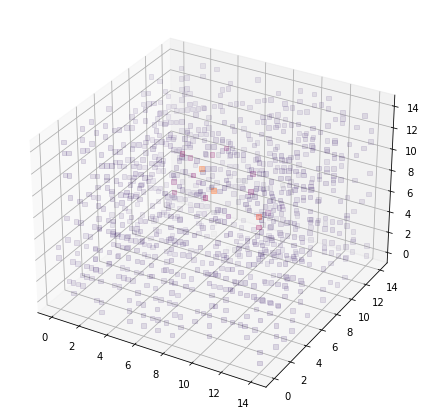

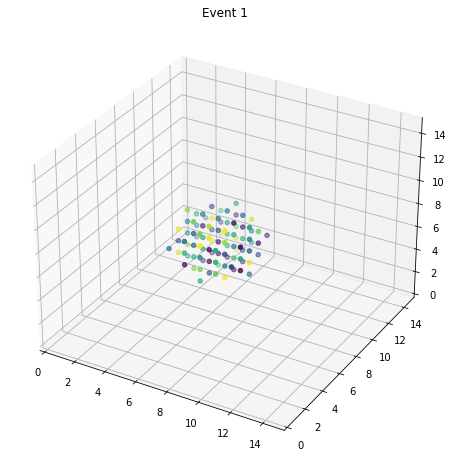

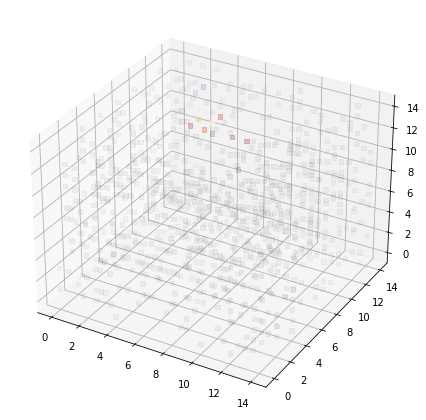

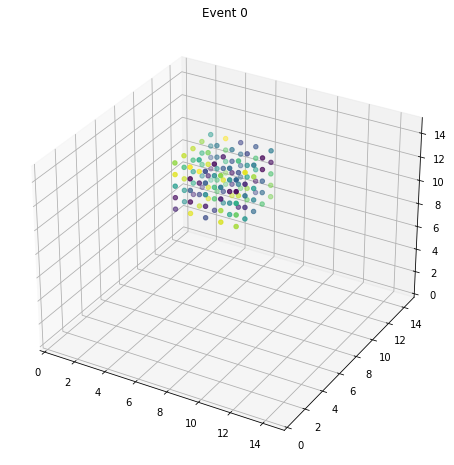

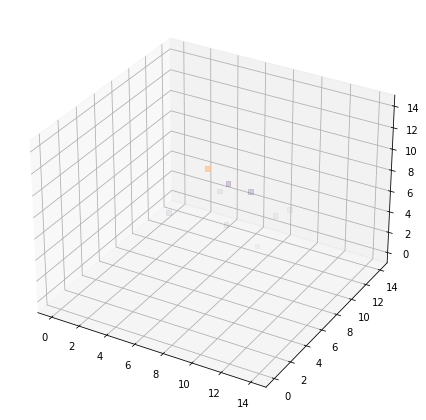

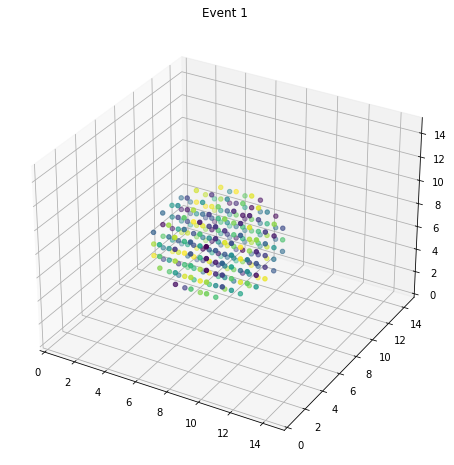

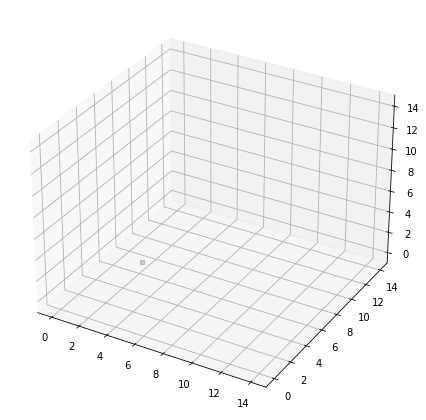

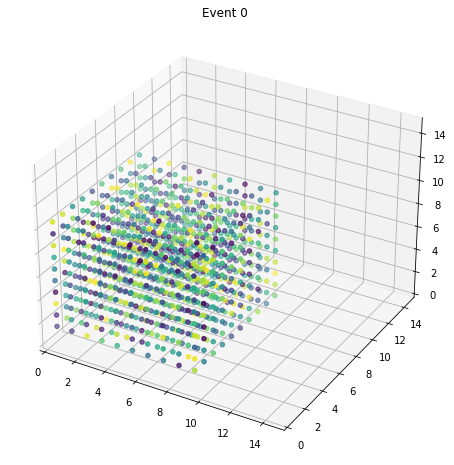

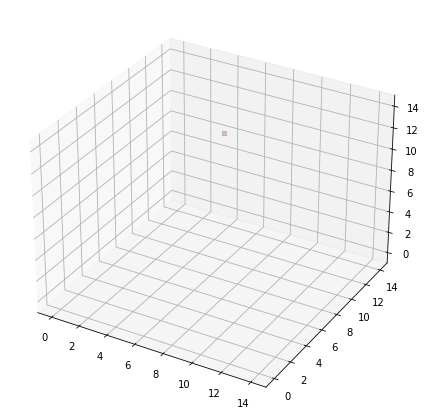

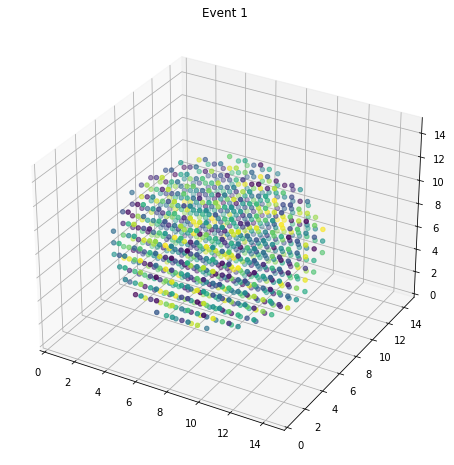

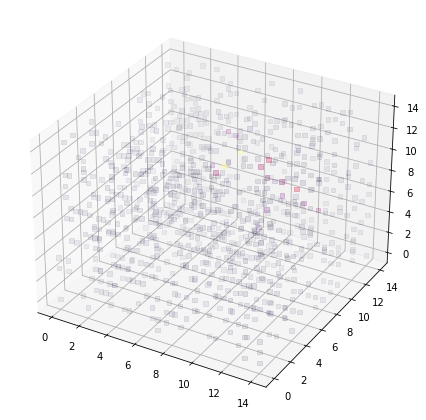

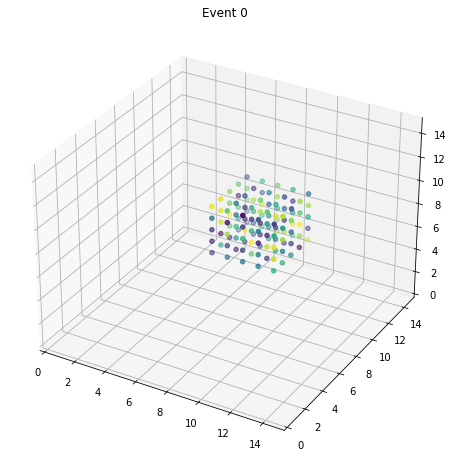

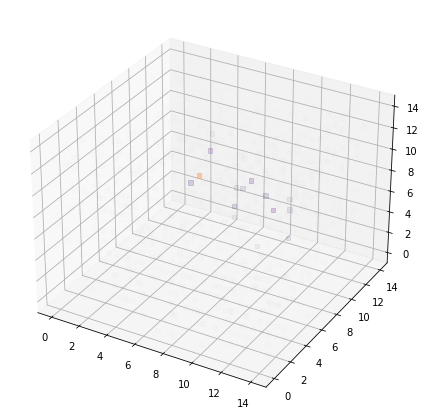

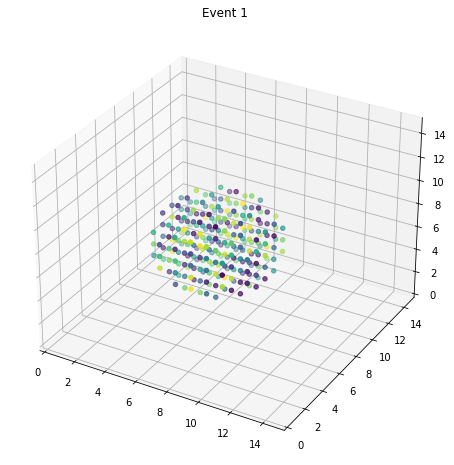

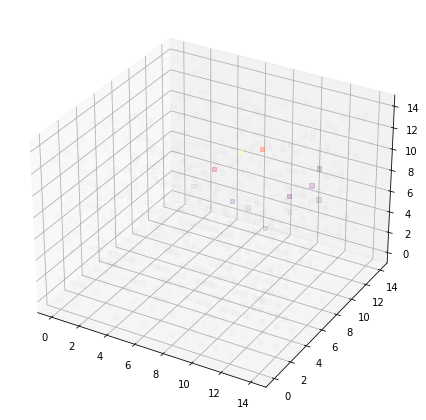

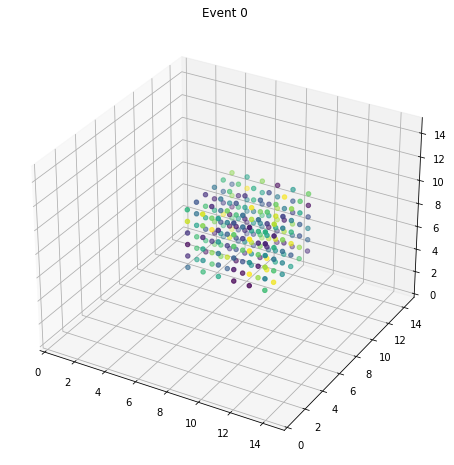

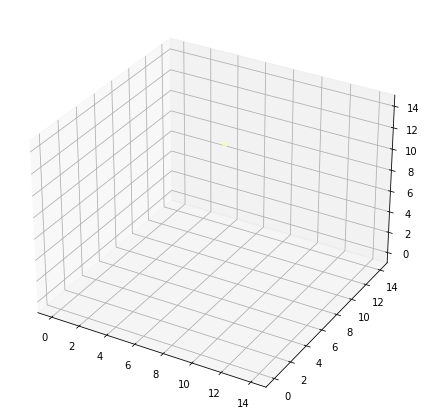

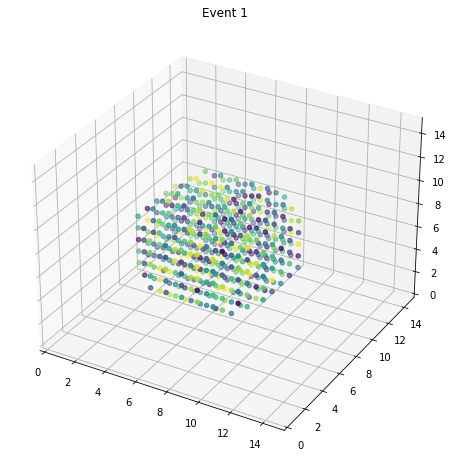

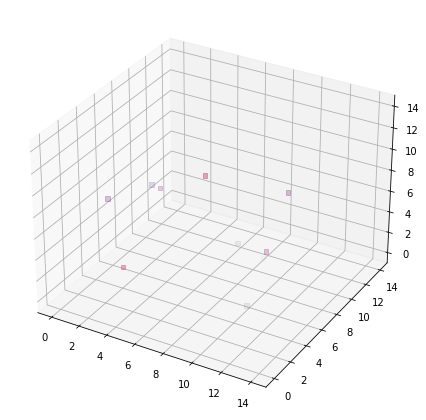

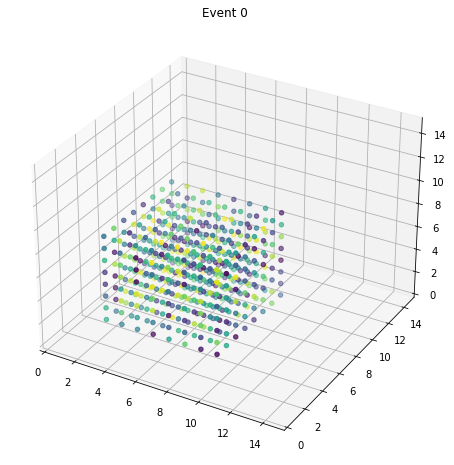

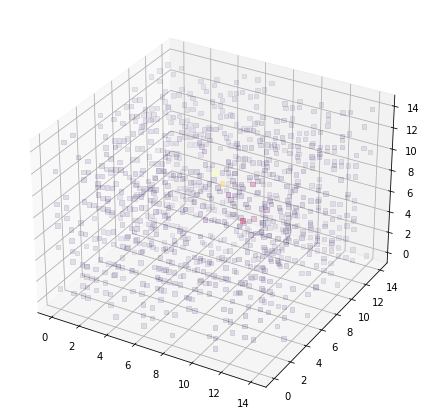

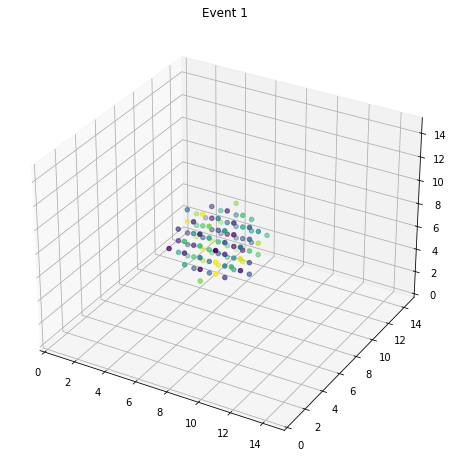

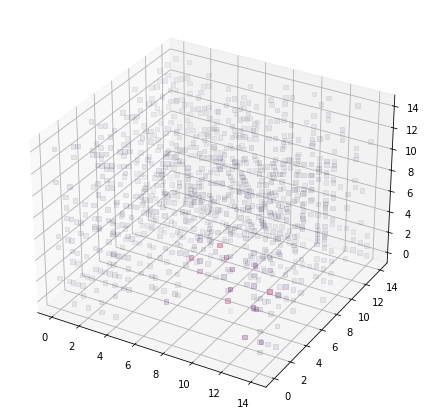

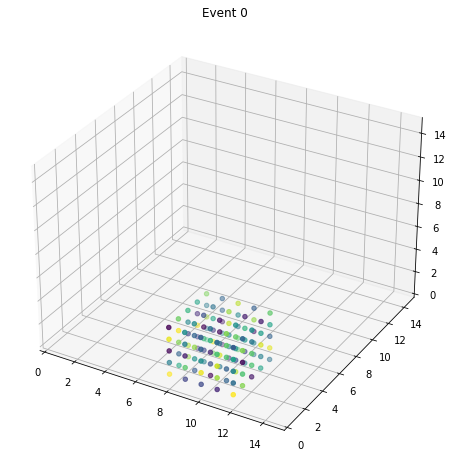

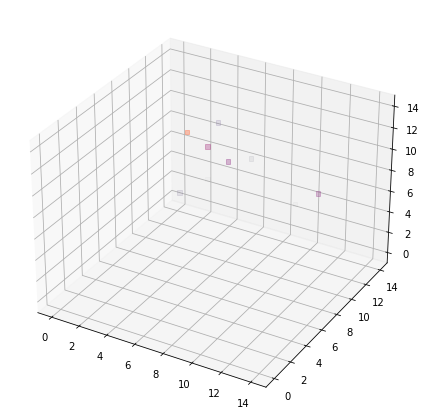

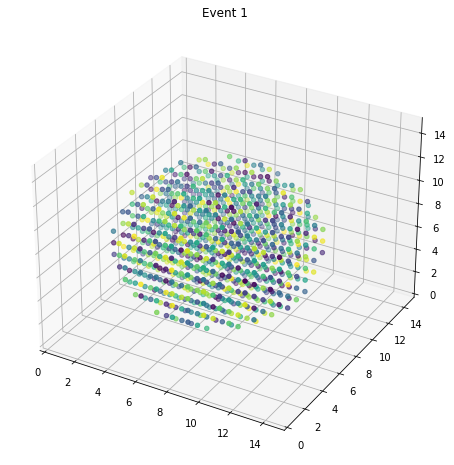

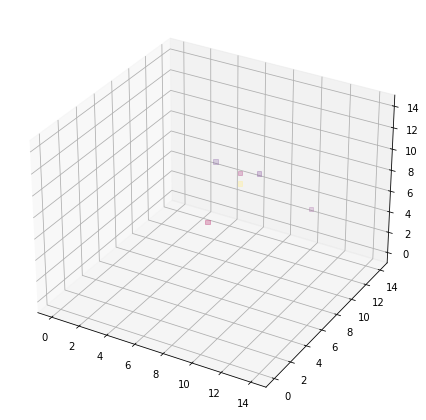

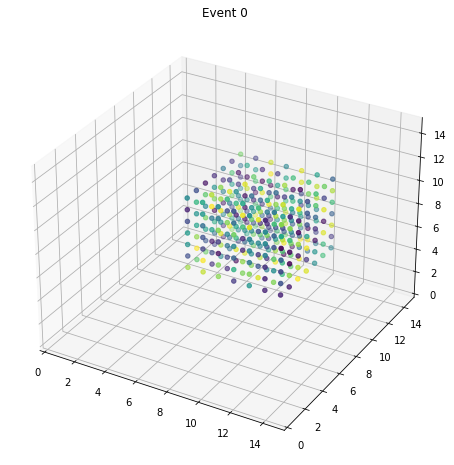

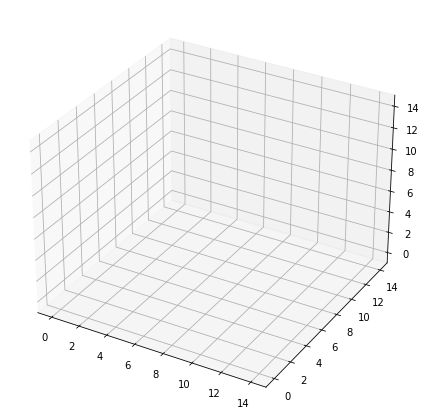

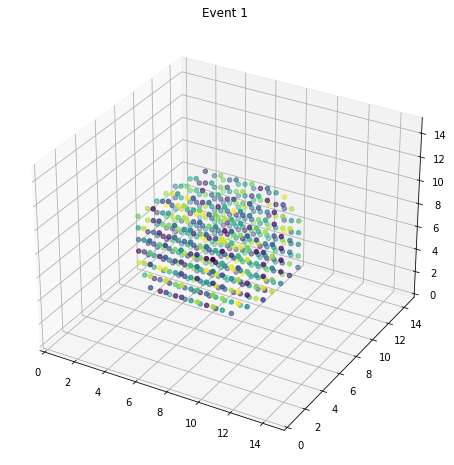

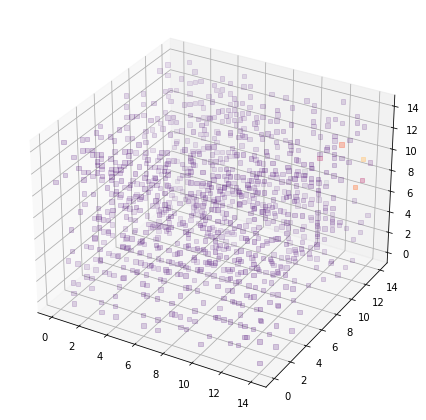

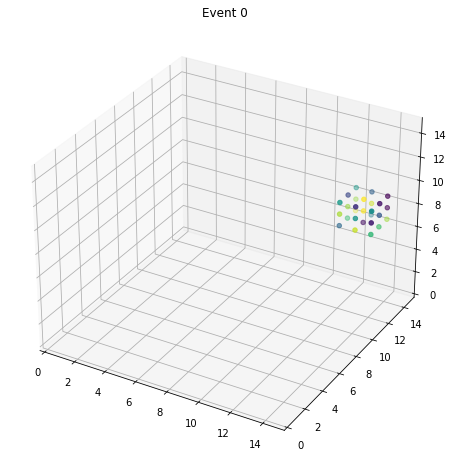

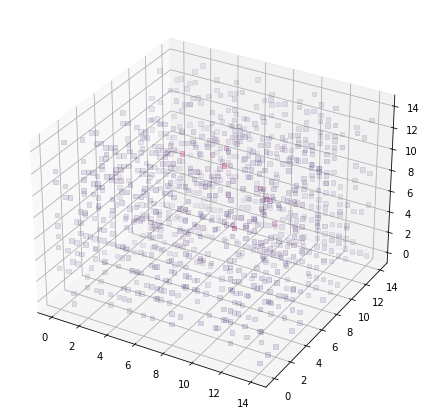

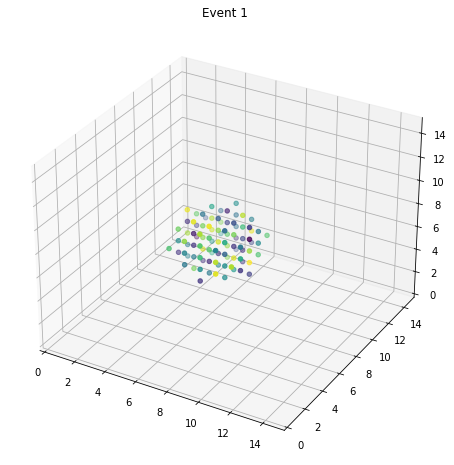

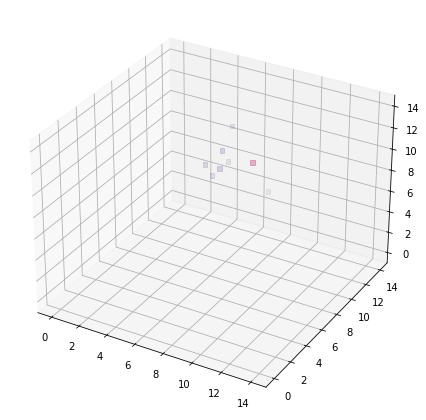

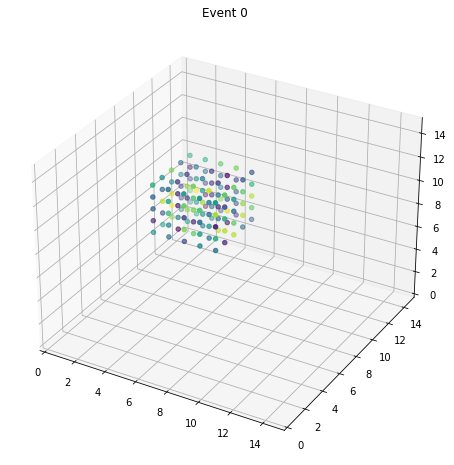

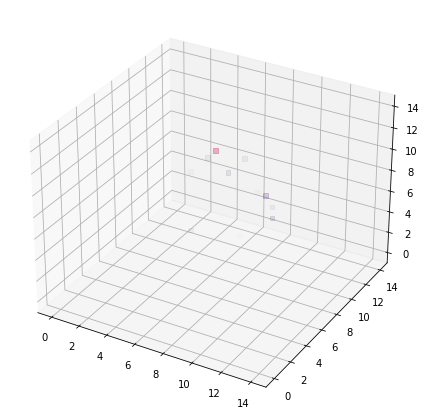

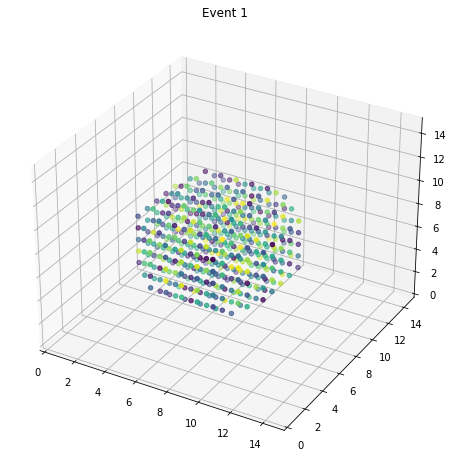

In [294]:
for i in range(20):

    grad_cam = compute_grad_cam(model, target_layer, updated_dataset_tensor[i:i+1], class_indices[i])
    plot_3d_voxels(grad_cam.numpy(),transparency_threshold=0,multi_view=False)

    data = updated_dataset[i, :, :, :, 0]

    fig = plt.figure(figsize=(16, 8))

    # Plot for the event
    ax1 = fig.add_subplot(111, projection='3d')
    x, y, z = np.where(data > 0)
    c = data[x, y, z].flatten()
    scatter = ax1.scatter(x, y, z, c=c, cmap='viridis')

    ax1.set_xlim([0, 15])
    ax1.set_ylim([0, 15])
    ax1.set_zlim([0, 15])
    ax1.set_title(f"Event {class_indices[i]}")

    plt.show
    

In [263]:
grad_cam.numpy().shape,updated_dataset[i, :, :, :, 0].shape

((15, 15, 15, 1), (15, 15, 15))

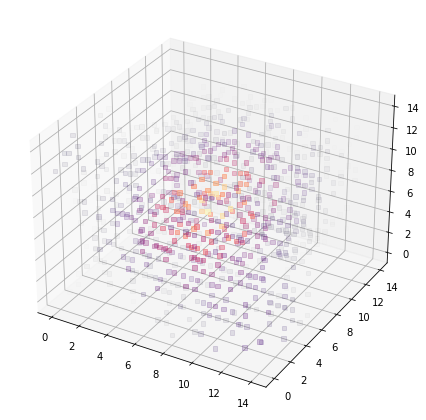

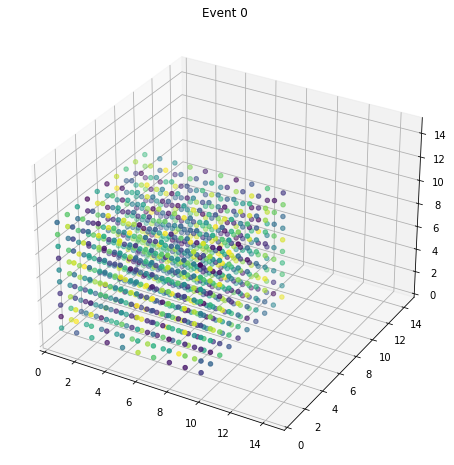

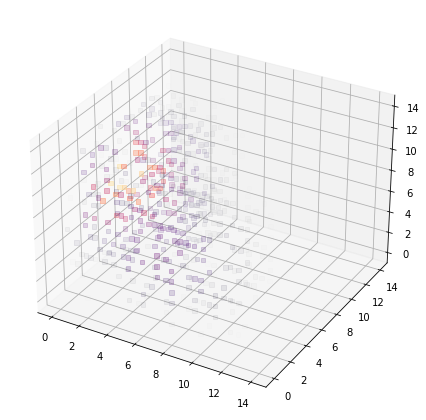

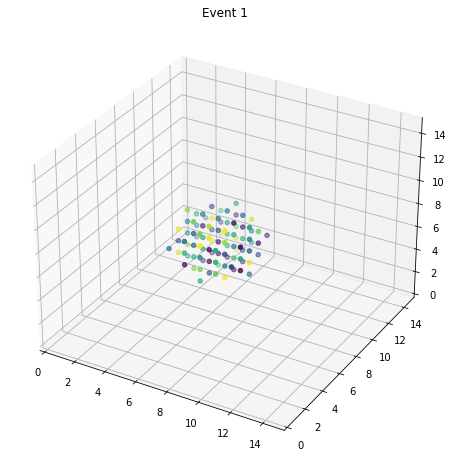

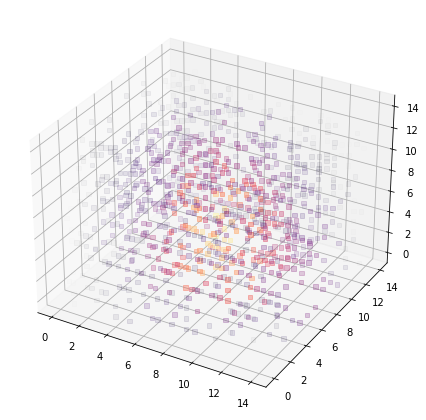

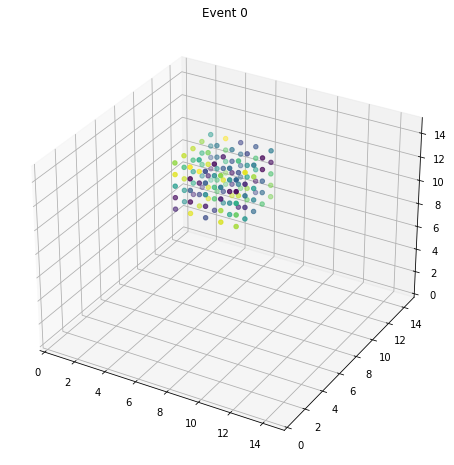

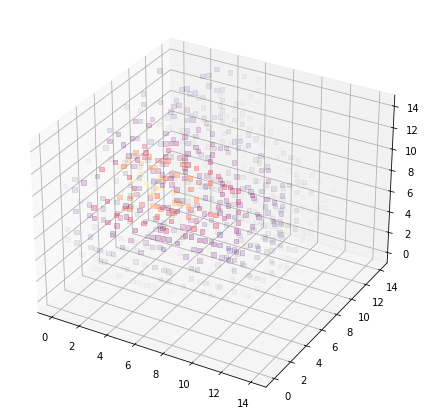

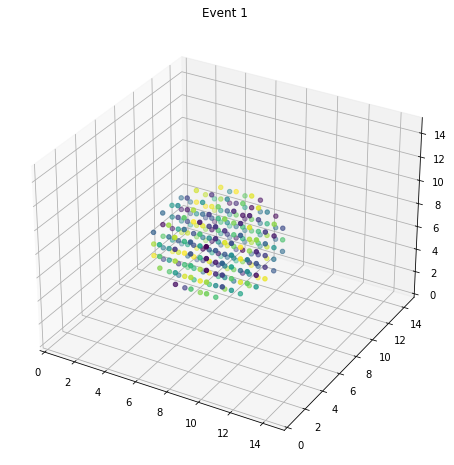

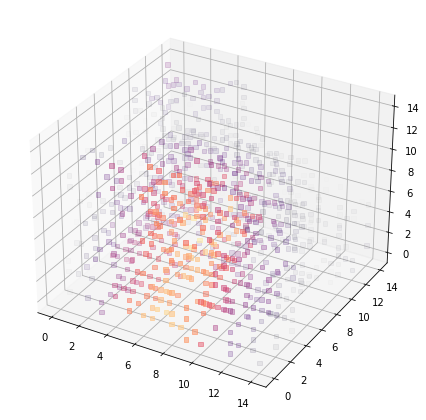

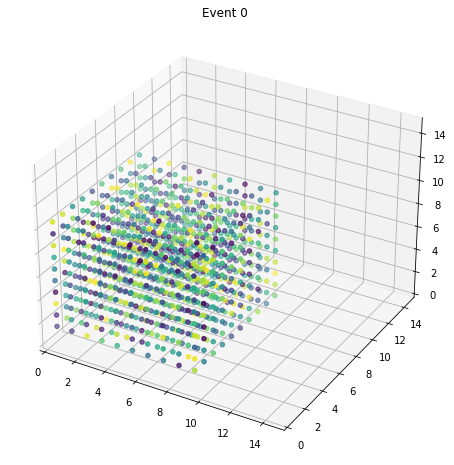

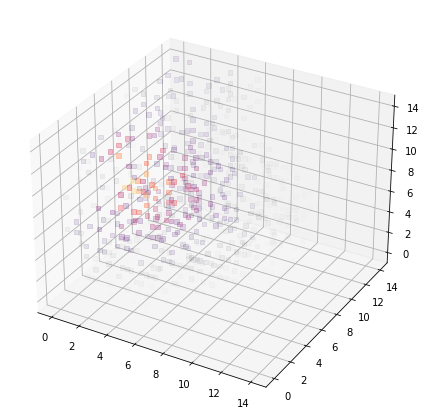

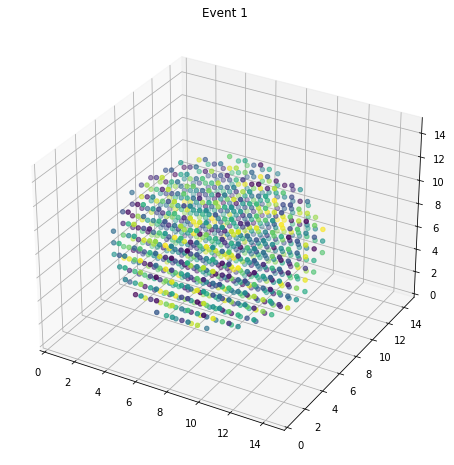

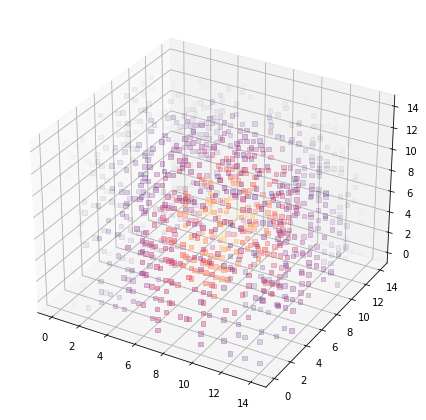

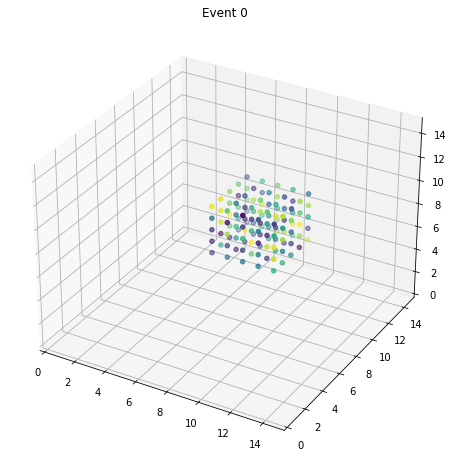

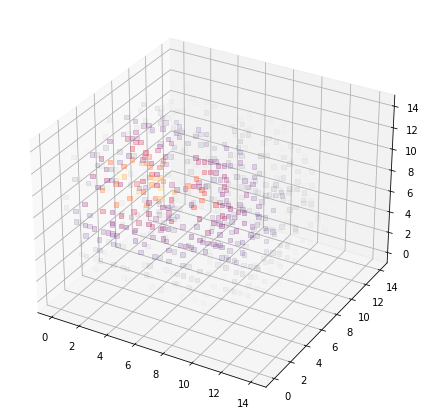

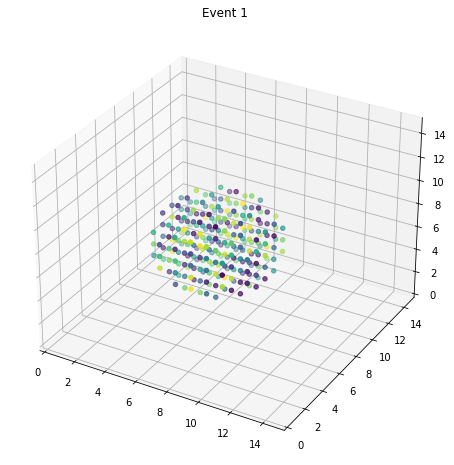

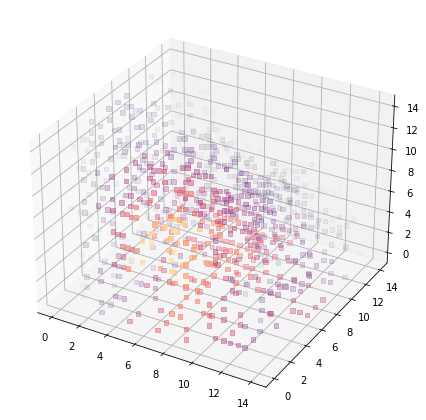

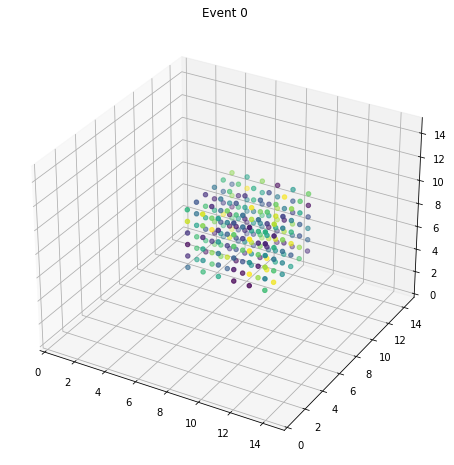

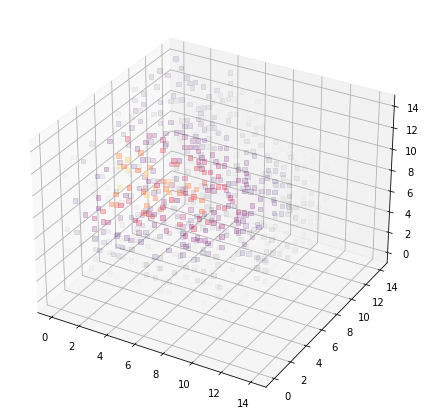

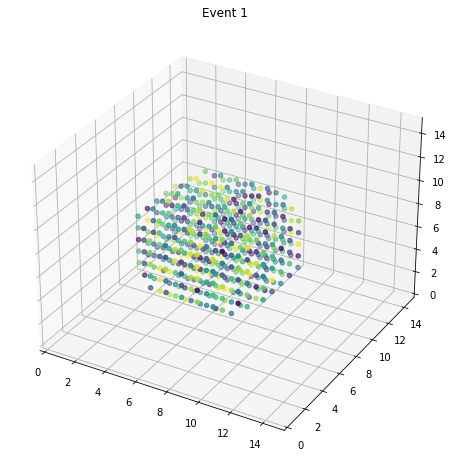

In [275]:
for i in range(10):
    
    grad_cam = compute_grad_cam(model, target_layer, updated_dataset_tensor[i:i+1], class_indices[i])
    plot_3d_voxels(grad_cam.numpy(),transparency_threshold=0,multi_view=False)

    data = updated_dataset[i, :, :, :, 0]

    fig = plt.figure(figsize=(16, 8))

    # Plot for the event
    ax1 = fig.add_subplot(111, projection='3d')
    x, y, z = np.where(data > 0)
    c = data[x, y, z].flatten()
    scatter = ax1.scatter(x, y, z, c=c, cmap='viridis')

    ax1.set_xlim([0, 15])
    ax1.set_ylim([0, 15])
    ax1.set_zlim([0, 15])
    ax1.set_title(f"Event {class_indices[i]}")
    plt.show


In [296]:
input_image.shape

(15, 15, 15)

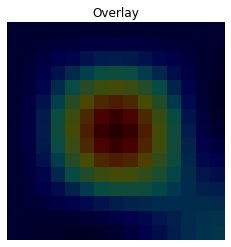

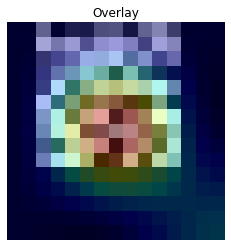

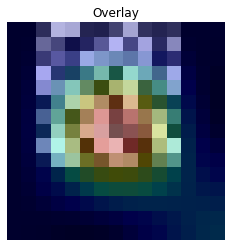

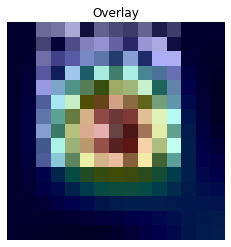

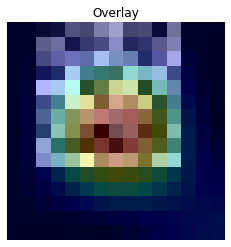

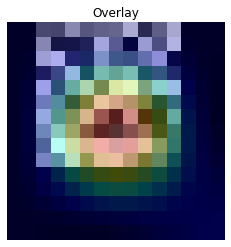

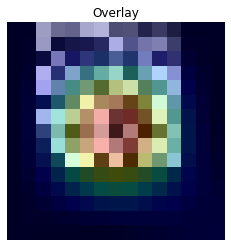

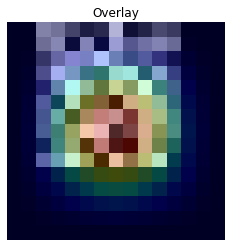

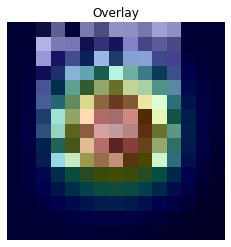

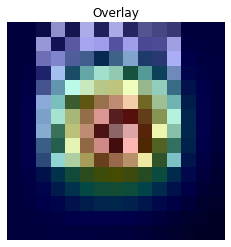

In [279]:
import matplotlib.pyplot as plt

def plot_data_with_heatmap(data_slice, heatmap_slice, title="Overlay", alpha=0.3):
    plt.imshow(data_slice, cmap='gray')  # Plot the data slice
    plt.imshow(heatmap_slice, cmap='jet', alpha=alpha)  # Overlay the heatmap slice
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage:
for slice_index in range(10):
    #slice_index = 7  # Example slice index
    data_slice = input_image[slice_index, :, :]  # Get a slice of the original data
    heatmap_slice = grad_cam[slice_index, :, :]  # Get the corresponding slice of the heatmap
    plot_data_with_heatmap(data_slice, heatmap_slice)

In [257]:
grad_cam_maps2 = []
for i in tqdm(range(100)):#input_data.shape[0]
    grad_cam = compute_grad_cam(model, target_layer, updated_dataset_tensor[i:i+1], class_indices[i])
    grad_cam_maps2.append(grad_cam)
grad_cam_maps2 = np.array(grad_cam_maps2)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.53it/s]


In [227]:
grad_cam_maps2.shape

(100, 15, 15, 15, 1)

In [ ]:
from VoxelPlotter import plot_3d_voxels

In [244]:
updated_dataset[i:i+1,:,:,:,0].shape

(1, 15, 15, 15)

In [232]:
def interactive_plot_with_saliency(event, azim, elev):
    data = updated_dataset[event, :, :, :, 0]
    saliency_data = grad_cam_maps2[event, :, :, :,0]

    fig = plt.figure(figsize=(16, 8))

    # Plot for the event
    ax1 = fig.add_subplot(121, projection='3d')
    x, y, z = np.where(data > 0)
    c = data[x, y, z].flatten()
    
    scatter = ax1.scatter(x, y, z, c=c, cmap='viridis')
    ax1.view_init(azim=azim, elev=elev)
    ax1.set_xlim([0, 15])
    ax1.set_ylim([0, 15])
    ax1.set_zlim([0, 15])
    ax1.set_title(f"Event {event}")

    # Plot for the saliency map
    ax2 = fig.add_subplot(122, projection='3d')
    x, y, z = np.where(saliency_data > 0)
    
    c = saliency_data[x, y, z].flatten()
    scatter2 = ax2.scatter(x, y, z, c=c, cmap='hot')  # Using a different colormap for clarity
    ax2.view_init(azim=azim, elev=elev)
    ax2.set_xlim([0, 15])
    ax2.set_ylim([0, 15])
    ax2.set_zlim([0, 15])
    ax2.set_title(f"Saliency Map for Event {event}")

    plt.show()

# Interactive widgets
widgets.interactive(interactive_plot_with_saliency, event=event_slider, azim=azim_slider, elev=elev_slider)


interactive(children=(IntSlider(value=33, description='Event'), IntSlider(value=120, description='Azimuth', ma…

In [174]:
grad_cam_maps2.shape

(10, 1, 15, 15, 15, 1)

In [180]:
grad_cam_maps2[0,0,:,:,0]

array([[[0.0704194 ],
        [0.07046374],
        [0.0705781 ],
        [0.07073446],
        [0.07090481],
        [0.07106118],
        [0.07117553],
        [0.07121987],
        [0.07117553],
        [0.07106118],
        [0.07090481],
        [0.07073446],
        [0.0705781 ],
        [0.07046374],
        [0.0704194 ]],

       [[0.07040955],
        [0.07045455],
        [0.07057062],
        [0.0707294 ],
        [0.07090253],
        [0.07106161],
        [0.07117829],
        [0.07122419],
        [0.0711804 ],
        [0.07106572],
        [0.07090847],
        [0.07073693],
        [0.07057938],
        [0.07046411],
        [0.0704194 ]],

       [[0.07039206],
        [0.07043827],
        [0.07055754],
        [0.0707208 ],
        [0.07089901],
        [0.0710631 ],
        [0.07118404],
        [0.07123276],
        [0.07118986],
        [0.0710745 ],
        [0.0709155 ],
        [0.07074168],
        [0.07058185],
        [0.07046481],
        [0.0704194 ]],

    

In [179]:
import numpy as np
import matplotlib.pyplot as plt

def overlay_3d_heatmap(input_image, heatmap):
    # Assuming heatmap is of shape (15, 15, 15, 1, 3), remove the singleton dimension
    heatmap = np.squeeze(heatmap, axis=3)

    # Preparing an array for the overlayed slices
    overlayed_slices = []

    # Iterate over each slice
    for i in range(heatmap.shape[0]):
        input_slice = input_image[i, :, :]
        heatmap_slice = heatmap[i, :, :]

        # Normalize the input slice and heatmap slice for visualization
        norm_input_slice = (input_slice - np.min(input_slice)) / (np.max(input_slice) - np.min(input_slice) + 1e-8)
        norm_heatmap_slice = (heatmap_slice - np.min(heatmap_slice)) / (np.max(heatmap_slice) - np.min(heatmap_slice) + 1e-8)

        # Overlay the heatmap onto the input slice
        overlayed_slice = norm_heatmap_slice * 0.5 + np.expand_dims(norm_input_slice, axis=-1) * 0.5
        overlayed_slices.append(overlayed_slice)

    return np.array(overlayed_slices)

# Example usage
overlayed_slices = overlay_3d_heatmap(input_image, grad_cam_map)

# Display a few slices as an example
for i in range(0, overlayed_slices.shape[0], 5):  # Display every 5th slice
    plot_3d_voxels(overlayed_slices[i])
    plt.title(f'Slice {i}')
    plt.axis('off')
    plt.show()


ValueError: Input data must be a 4D numpy array